# Lecture 7: Risk Backtesting and Forecasting

So far, we have learned how to take a series of risk factors, map them to a loss distribution and use that distribution to define various risk measures (most notably, VaR and CVaR). This lecture will cover how to control, that is to review and assess the quality of a risk models you are using by backtesting or stress testing. This is done with the goal of overall improvement. 

The main topics of discussion are the following:

 1. Forecasting
 2. Backtesting
 3. VaR estimation: a practical example
 


In [1]:
#Importing standard libraries

import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Forecasting 

In simple terms, forecasting is the act of taking historical data, assuming a model which you fit to that data by optimizing for certain parameters $\vec{\theta}$, and using that model to try and _predict_ the future. 

One (rather terrible) example is using a polynomial fitting (see lecture 4) to predict stock prices, as will be done in the following code block:

In [2]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance
from scipy.optimize import curve_fit ## Function to fit dataset to function

def get_stock_price(ticker, start='2016-01-01', end='2020-12-31',price_type = 'Adj Close'): ##function from lecture 1
    return data.DataReader(ticker,'yahoo',start,end)[price_type]

training_data = list(get_stock_price('GOOG')) #google price data as a list

q_eq_5 = lambda t,a,b,c,d,e,f: a + b*t + c*(t**2) + d*(t**3) + e*(t**4) + f*(t**5) #polynomial function of order 5

model = curve_fit(q_eq_5,list(range(len(training_data))),training_data) #estimated beta values (params of best fit)

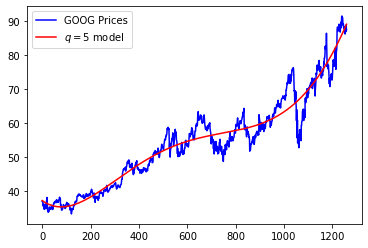

In [3]:
plt.plot(training_data,color='blue',label='GOOG Prices') #plotting stock data
plt.plot([q_eq_5(i,*model[0]) for i in range(len(training_data))],color='r',label=r'$q = 5$ model')#plotting the model
plt.legend()

As you can see, this polynomial fit follows the trend of GOOG prices from new year 2016 to new year 2021. Let us try to use this model to forecast prices throughout 2021 and 2022.

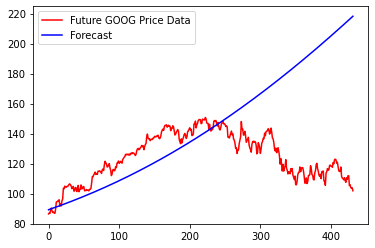

In [4]:
test_data = list(get_stock_price('GOOG', start='2021-01-01', end='2022-09-20')) ##Future data 

forecast = [q_eq_5(i,*model[0]) for i in range(len(training_data), len(training_data)+len(test_data))] #Forecast

plt.plot(test_data, color='r',label='Future GOOG Price Data')
plt.plot(forecast, color='b', label='Forecast')
plt.legend()

As you can see, the trend forecast is not too bad for the first ~200 days after the training period but gets increasingly worse later on. In fact, let us plot the error over time

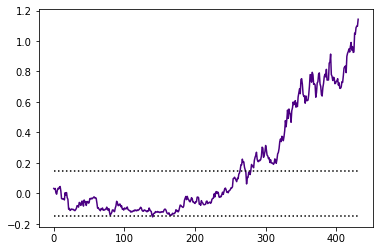

In [5]:
resid = [(forecast[i] - test_data[i])/test_data[i] for i in range(len(test_data))]

plt.plot(resid,color='indigo')
plt.plot([0.15 for i in range(len(test_data))],linestyle='dotted',color='black')
plt.plot([-0.15 for i in range(len(test_data))],linestyle='dotted', color='black')

Setting a 15 percent tolerance, we can see that the error greatly starts to diverge from the tolerance as time goes on. 

The data in the "training period" (i.e 2016-2021) is known as the _in-sample_ data. As you can see the model does a very good job of estimating the trend there. Although, the story is different for the _out-of-sample_ data (i.e the "testing period", 2021-2022).

Another example of estimating and forecasting is recording the height of highschool students and fitting it to a normal distribution with $\vec{\theta} = \{\mu,\sigma^2\}$ (that is, estimating the parameters) and using this model to forecast the distribution of height in the next 20 years (weird example as height tends to be constant in such short timeframes).

## Backtesting

In simplest terms, backtesting is the act of testing the out-of-sample fit of a model. One does that by applying the model to historical data and then reviewing the adequacy of the model. The procedure for backtesting VaR is:

 - estimation of a parametric VaR model based on sample data
 - forecastof out-of-sample values as VaR barrier 
 - comparison of predicted VaR-barriers and realized values (i.e number of VaR exceedences -- see lecture 6)
 - evaluation of different quality characteristics of VaR forecast

Or in simpler terms:

First, you must divide your sample data into "training data" and "testing data". You then use the training data to employ one of VaR estimation (see lecture 6). After that, you must use some model such as ARCH or GARCH to forecaste the VaR beyond the training data. Apply that forecasting model to the testing data and see when VaR exceedences occur. And finally, compare that to the actual VaR exceedences. This comparison should determine the quality of the forecasting model.

The "quality" of a VaR model is described by what is called _Unconditional Coverage_. A low quality model can have one of two issues: 1. VaR exceedance happens way more than anticipated. This would result in a risk tolerance that is too high (and may lose an account manager a lot of money). 2. VaR exceedences happen way less than anticipated. This would result in an account manager having too low of a risk apetite, and therefore sacrificing potential profits. 

The following are examples of an innappropriately high and low VaR, respectively:


<table><tr>
<td> <img src="assets/pussy.png"style="width: 400;"/> </td>
<td> <img src="assets/yolo.png" style="width: 400;"/> </td>
</tr></table>

The first asset manager will miss out on some good trades or holdings, whilst the second will likely YOLO the account (literally only exceeds VaR once in four years lol). 

It is called unconditional coverage because we are not interested in _when_ these VaR exceedances happen, but simply how many times (again, see Lecture 6) and the proper way to test it is to see if percentage of expected VaR exceedences $\approx$ confidence level $\alpha$, i.e the hypothesis is 

$$\mathbb{E}[h_t(\alpha) - \alpha] = 0$$

where $h_t(\alpha) = 1$ if there is a VaR exceedance at $t$ and 0 otherwise. The most popular test for unconditional coverage is the _Kupiec Test_, which has the following test statistic:

$$K_n = \frac{1}{\sqrt{n}}\sum_{i = 1}^n [h_t(\alpha) - \alpha]$$

which essentially sums up the number of VaR exceedances, gets its difference with $\alpha*n$ and divides the result by $\sqrt{n}$, kind of like an average of the exceedances. Under the assumption that exceedences are Binomially (in fact, Bernouli) distributed, i.e $h_t(\alpha) \sim Bin(1,\alpha)$, $K_n$ becomes normally distributed where one can use 

$$\mathbb{E}[h_t(\alpha)] = \alpha$$ 

as a moment of this distribution. For more information on this test, I have linked a paper in the "Further Reading" folder. 


The Kupiec Test is accepted or rejected based on only how many VaR exceedances there are. Although note that if we have, for example, $\vec{h_t} = 000011111111110000000001111111$ (i.e exceedances happen in clusters), we can know that this is not a good model as $\{h_t(\alpha)\}^n_{t=1} \sim iid$. To resolve this issue, simuoultanious backtests have been created to test for both how many VaR exceedances have occured and also how they are distributed. Such methods use the autocorrelation function $\kappa_j = Cov[h_t, h_{t + j}]$ where $j \geq 1$. For more info on that, I've also linked the original paper of the most common method under "Further Reading".

## VaR: A practical Example

Consider an asset manager that has been given 10,00 USD to allocate in the following portfolio: [\\$IBM, [\\$GOOG,\\$TSLA, \\$MSFT] with weight vector $\vec{w} = \{0.1,0.4,0.35, 0.15\}$. 

Our goal is to build and backtest a VaR ($\alpha = 0.95,\Delta$=1 day) forecasting model that uses the portfolio daily returns from New Year 2016 - New Year 2020 as the in-sample data and daily portfolio returns from New Year 2020 - New Year 2022 as the out of sample data.

### Step 1: Get Data and Split into In and Out of Sample


Let us use the `get_stock_price()` function defined above to get all the ticker data once we construct our portfolio.

In [10]:
portfolio_value = 10000 #cash given to asset manager
tickers = ["IBM", "GOOG", "TSLA", "MSFT"] # portfolio
weights = [0.1,0.4,0.35,0.15] #weights

constituent_returns = [get_stock_price(i,start="01-01-2016",end="01-01-2022") for i in tickers] #individual returns 

Mean Daily Portfolio Return:  0.162 %
Std. Dev Portfolio Return:  1.851 %
Total Return: 115393 USD


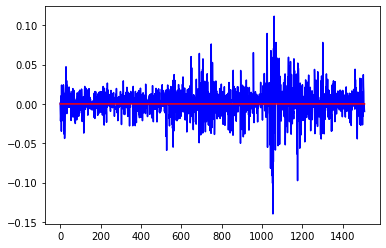

In [53]:
portfolio_returns = [sum([weights[i]*((constituent_returns[i][j+1] - constituent_returns[i][j])/constituent_returns[i][j])for i in range(len(tickers))]) for j in range(len(constituent_returns[0]) - 1)]
#daily portfolio returns



plt.plot(portfolio_returns,color='blue') #plotting portfolio returns
plt.plot([0 for i in range(len(portfolio_returns))], color='red') #baseline for visual purposes


#Some stats about our portfolio
print('Mean Daily Portfolio Return: ', round(np.mean(portfolio_returns)*100,3),"%")
print('Std. Dev Portfolio Return: ', round(np.std(portfolio_returns)*100, 3),"%")
print('Total Return:', round((1 + np.mean(portfolio_returns))**(252*6) * portfolio_value),"USD")



As you can see our portfolio does a decent job in a returns context. We can also see that there is a large variability in variance, for example, the Covid crash at around $t = 1050$. Very cool.  Now it's time to get to work. Let us start by splitting the data into training and testing data.

In [58]:
training_data = portfolio_returns[:int(len(portfolio_returns)*4/6)] #training data
testing_data = portfolio_returns[int(len(portfolio_returns)*4/6):] #testing data

training_data + testing_data == portfolio_returns # sanity check

True

### Step 2. Getting the Historical VaR of the portfolio for in-sample


Now that our data is ready, we will start by calculating the VaR for the portfolio using the historical simulation method (for refresher, look at Lecture 6). 

VaR at day 1000: -386.04255281537775 USD


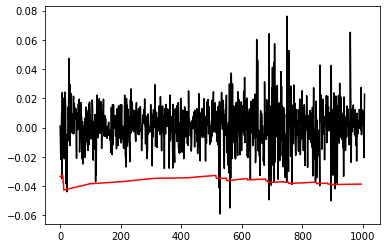

In [370]:
VaRs = []
for i in range(1,len(training_data)):
    VaRs.append(np.percentile(training_data[:i],0.95)) #Re-calculating VaR estimate everyday

plt.plot(training_data, color='black') #Plotting daily returns 
plt.plot(VaRs[10:],color='red')#Plotting all values of VaR except for when t ɛ (0,10) because it is innaccurate

print("VaR at day 1000:", VaRs[1000]*portfolio_value,"USD")

### Step 3: Building Forecasting Model

Now that we've calculated VaR data, it is time to fit it into a model, say,  GARCH(1,1). If you need a refresher, see Lecture 5. 

In [80]:
#Ignore the following code, it just removes the ugly warnings from the code blocks bellow:

############################################################################################
import warnings
warnings.filterwarnings('ignore')
############################################################################################

In [401]:
from arch import arch_model

sigma_estimate = arch_model(training_data, p=1, q=1,dist='normal') 
sigma_estimate = sigma_estimate.fit() ## fitting the training data to a GARCH(1,1) model

sigma_estimate.summary()



Iteration:      1,   Func. Count:      6,   Neg. LLF: 321673417.582857
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1.5244206647165836e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2862.4363683691067
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2862.44
Distribution:                  Normal   AIC:                          -5716.87
Method:            Maximum Likelihood   BIC:                          -5697.22
                                        No. Observations:                 1006
Date:                Thu, Sep 22 2022   Df Residuals:                     1005
Time:                        12:30:45   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0759e-03  3.248e-04      3.312  9.257e-04 [4.393e-04,1.713e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.3887e-06  5.277e-11  8.316e+04      0.000 [4.389e-06,4.389e-06]
alpha[1]       0.0500  1.448e-02      3.454  5.519e-04 [2.163e-02,7.837e-02]
beta[1]        0.9300  1.378e-02     67.472      0.000     [  0.903,  0.957]
============================================================================

Covariance estimator: robust
"""

Looking at the "Volatility Model" section at the bottom of the summary, one can see we get the statistically significant estimated parameters to be $\omega = 0, \alpha = 0.05, \beta = 0.93$. Let us now plot this estimation alongside the actual VaR data.

In [402]:
from scipy.stats import norm
forecast = sigma_estimate.forecast(horizon=len(training_data)).variance.values[-1, :]**0.5 #forecasting model with params above
forecast = [forecast[i]*norm.ppf(0.05) - np.mean(training_data[:i]) for i in range(len(forecast))]



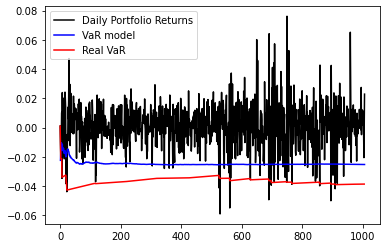

In [403]:
plt.plot(training_data, color='black',label="Daily Portfolio Returns")
plt.plot(forecast,color='blue', label="VaR model")
plt.plot(VaRs,color='red', label="Real VaR")
plt.legend()

We can already see with the in-sample data that this is not a good model. In general, it is good practice to ditch a model if it doesn't work with the in-sample data, although for pedagogical reasons we will carry on with this.

### Step 4: Applying VaR model on Testing Data